# The optimization is emerging as a major pain point

Interim conclusion: call it good enough. Different problems might need different hyperparameters, but for now, set them online.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import torch

In [2]:
from cgf_network import CGF_ICNN

## Simple one dimensional gaussian

In [3]:
ckpt = 'trainedParameters/figures/normal_model/validation-epoch=214-step=32035.ckpt'
data = torch.randn(5000, 1)
optimal_model = CGF_ICNN.load_from_checkpoint(ckpt, data_to_model=data)

Reasonable fit. Note that this generated data is different from the data that the model was fit on.

Why is the change always the same??

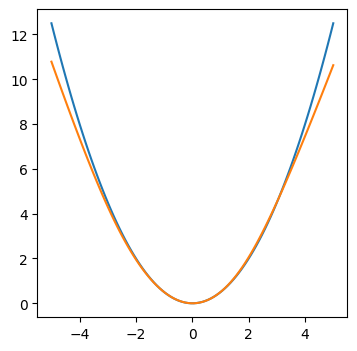

In [4]:
figsize(4,4)
thetas = torch.linspace(-5,5,100)
plt.plot(thetas, 0.5*thetas**2)
plt.plot(thetas, optimal_model.fwd_cpu(thetas[:,None]).detach())

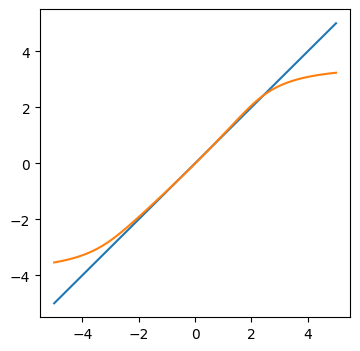

In [5]:
plt.plot(thetas, thetas)
plt.plot(thetas, optimal_model.jac(thetas[:, None]).detach())

pretty much accurate

#### Adam optimizer

In [6]:
mus = torch.linspace(-5, 5, 100)

thetas_out, Is = optimal_model.dual_opt(mus[:, None])

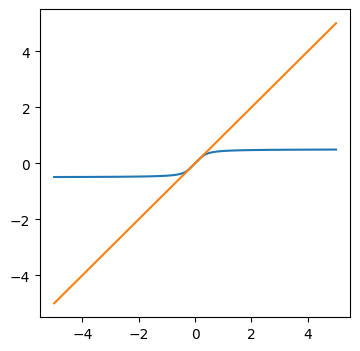

In [7]:
plt.plot(mus,  optimal_model.jac(thetas_out.detach()).detach())
plt.plot(mus, mus)

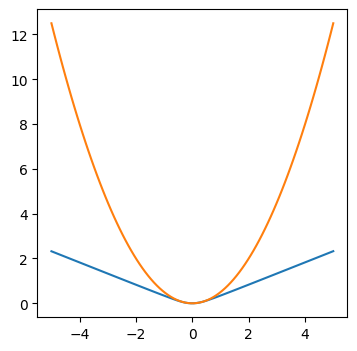

In [8]:
plt.plot(mus, Is.detach())
plt.plot(mus, 0.5*mus**2)

These dual outputs are very poor. Note that the strong function fits, and the advantage of the ground truth seem to indicate that there is no problem with the learned network, rather with the optimization.

1. Adam uses per parameter learning rates which sparsify the parameters (here, the individual values of x). Seems to result in sparse fits along the x axis.

#### SGD

In [9]:
mus = torch.linspace(-5, 5, 100)

thetas_out, Is = optimal_model.dual_opt(mus[:, None], optim_method=torch.optim.SGD)

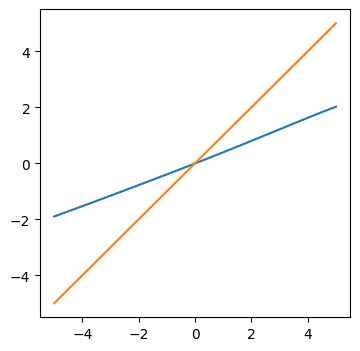

In [10]:
plt.plot(mus,  optimal_model.jac(thetas_out.detach()).detach())
plt.plot(mus, mus)

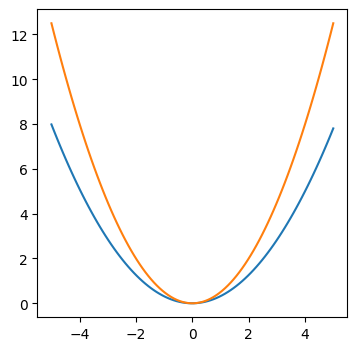

In [11]:
plt.plot(mus, Is.detach())
plt.plot(mus, 0.5*mus**2)

Oddly enough, this produces inputs with exactly half the outputs! Does that result from a local maximum or something?

In [12]:
def dual_opt_test(model, p, optim_method=torch.optim.SGD):
    """
        Solve the dual optimization problem.

        Note that issues may arise if the desired slope is not achieved
        by the CGF
    """
    def to_minimize(x):
        return -(torch.einsum('Nk, Nk -> N', p, x) - model.fwd_cpu(x).squeeze())

    input_val = torch.nn.Parameter(torch.zeros(p.shape))
    optimizer = optim_method((input_val,), lr=1E-2, momentum=0.9)
    
    for step in range(500):
        curr_val = optimizer.param_groups[0]['params'][0]
        optimizer.zero_grad()
        
        out = to_minimize(curr_val).sum()
        out.backward()
        optimizer.step()

    x_val = optimizer.param_groups[0]['params'][0].data
    
    return x_val, -to_minimize(x_val)

In [13]:
mus = torch.linspace(-5, 5, 100)

thetas_out, Is = dual_opt_test( optimal_model, mus[:, None], optim_method=torch.optim.SGD)

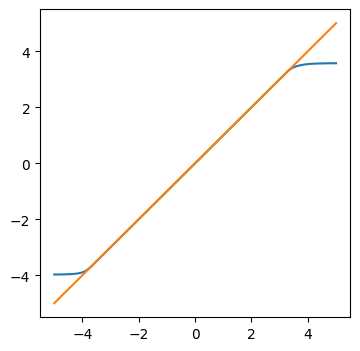

In [14]:
plt.plot(mus,  optimal_model.jac(thetas_out.detach()).detach())
plt.plot(mus, mus)

(0.0, 20.0)

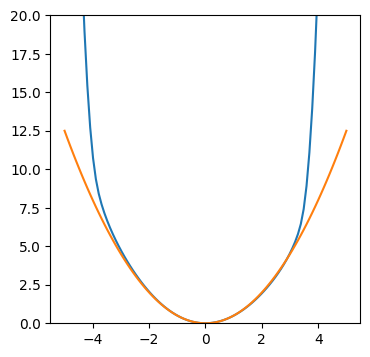

In [15]:
plt.plot(mus, Is.detach())
plt.plot(mus, 0.5*mus**2)
plt.ylim([0, 20])

In [16]:
mus = torch.linspace(-5, 5, 100)

thetas_out, Is = optimal_model.dual_opt( mus[:, None], optim_method=torch.optim.SGD, lr=1E-2, momentum=0.9)

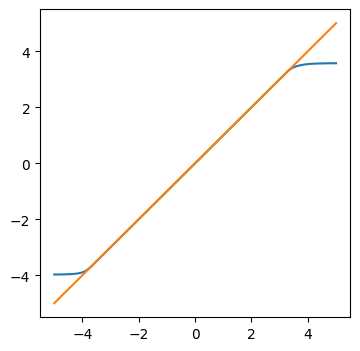

In [17]:
plt.plot(mus,  optimal_model.jac(thetas_out.detach()).detach())
plt.plot(mus, mus)

One dimensional models seem to do well with SGD and momentum

(array([ 5.,  4.,  5., 10., 54.,  6.,  4.,  4.,  4.,  4.]),
 array([-1.45808887, -1.13562763, -0.81316638, -0.49070513, -0.16824389,
         0.15421736,  0.47667861,  0.79913998,  1.1216011 ,  1.44406223,
         1.7665236 ]),
 <BarContainer object of 10 artists>)

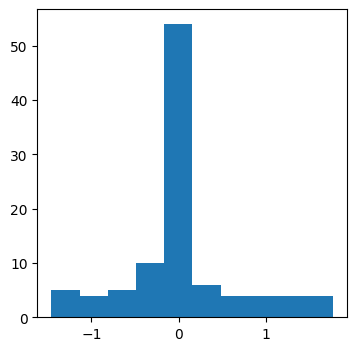

In [16]:
plt.hist((mus-optimal_model.jac(thetas[:, None]).squeeze()).detach())

There are a fair amount of misses. I think that this is because of the saturation objective slope.

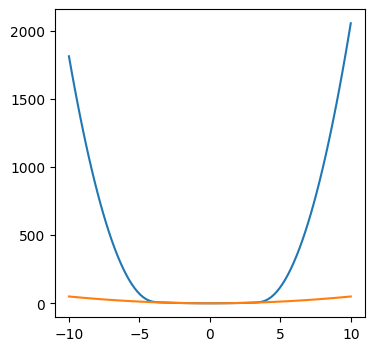

In [17]:
mus = torch.linspace(-10, 10, 100)

thetas_out, Is = dual_opt_test( optimal_model, mus[:, None], optim_method=torch.optim.SGD)

plt.plot(mus, Is.detach())
plt.plot(mus, 0.5*mus**2)

The $I$ values do blow up, but they can't go to infinity due to the finite step size.

## MNIST networks

In [18]:
%run models/simple_examples.py
%run cgf_network.py


classifier_ckpt ='./learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'

mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
mnist_model.setup()
mnist_model.fit_activity_transform(mnist_model.data_train)

activity_data, targets = mnist_model.internal_activity_dataset(mnist_model.data_train)[:]

mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_data)

<Figure size 400x400 with 0 Axes>

In [19]:
from scipy.stats import multivariate_normal

mean = mnist_cgf.jac(torch.zeros(1, 28))[0].detach()
cov = mnist_cgf.hess(torch.zeros(1, 28))[0].detach()

n_samples=100

sample_dist = multivariate_normal(mean=mean, cov=(1./n_samples)*cov)

In [20]:
def dual_opt_test(model, p, optim_method=torch.optim.SGD):
    """
        Solve the dual optimization problem.

        Note that issues may arise if the desired slope is not achieved
        by the CGF
    """
    def to_minimize(x):
        return -(torch.einsum('Nk, Nk -> N', p, x) - model.fwd_cpu(x).squeeze())

    input_val = torch.nn.Parameter(torch.zeros(p.shape))
    optimizer = optim_method((input_val,), lr=1E-3, momentum=0.8)
    
    for step in range(500):
        curr_val = optimizer.param_groups[0]['params'][0]
        optimizer.zero_grad()
        
        out = to_minimize(curr_val).sum()
        out.backward()
        optimizer.step()

    x_val = optimizer.param_groups[0]['params'][0].data
    
    return x_val, -to_minimize(x_val)

In [21]:
samples = torch.tensor( sample_dist.rvs(1000), dtype = torch.float)

In [22]:
thetas_sgd, Is_sgd = dual_opt_test(mnist_cgf, samples)
recovered_sgd = mnist_cgf.jac(thetas_sgd)

In [23]:
thetas_adam, Is_adam = mnist_cgf.dual_opt(samples)
recovered_adam = mnist_cgf.jac(thetas_adam)

(array([ 34., 134., 243., 279., 176.,  79.,  38.,   8.,   6.,   3.]),
 array([0.05157158, 0.07702585, 0.10248013, 0.1279344 , 0.15338868,
        0.17884295, 0.20429721, 0.2297515 , 0.25520575, 0.28066003,
        0.30611432]),
 <BarContainer object of 10 artists>)

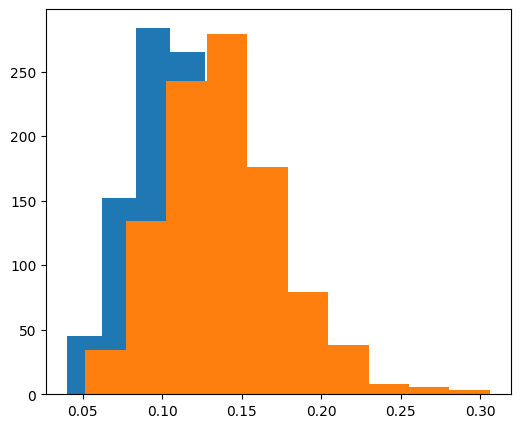

In [24]:
figsize(6,5)
plt.hist(Is_sgd.detach())
plt.hist(Is_adam.detach())

(array([  2.,   4.,   5.,  16.,  54.,  96., 200., 303., 250.,  70.]),
 array([-0.08378106, -0.07619525, -0.06860943, -0.06102362, -0.05343781,
        -0.04585199, -0.03826617, -0.03068036, -0.02309455, -0.01550873,
        -0.00792292]),
 <BarContainer object of 10 artists>)

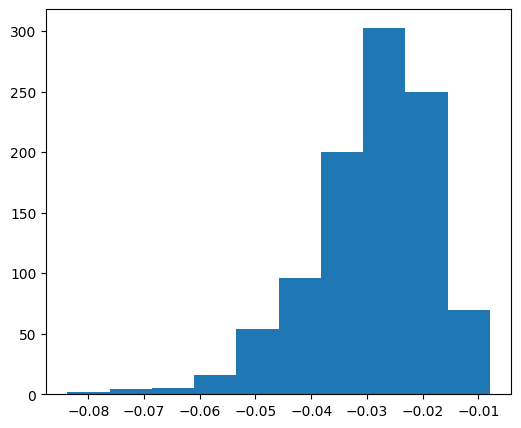

In [25]:
plt.hist((Is_sgd - Is_adam).detach())

Note that Adam _always_ recovers a better (larger) value than SGD

(array([139., 281., 252., 170.,  79.,  41.,  25.,   6.,   3.,   4.]),
 array([0.00135808, 0.01450737, 0.02765666, 0.04080596, 0.05395525,
        0.06710454, 0.08025384, 0.09340313, 0.10655242, 0.11970171,
        0.132851  ]),
 <BarContainer object of 10 artists>)

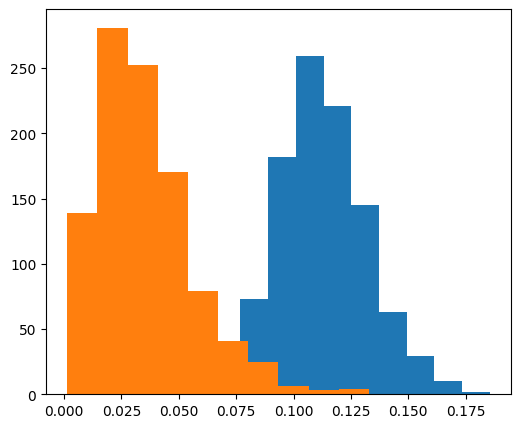

In [26]:
plt.hist(torch.norm((samples - recovered_sgd).detach(), dim=1))
plt.hist(torch.norm((samples - recovered_adam).detach(), dim=1))

Again, the Adam recoveries are massively closer to the original inputs.

#### Seemingly, these two settings need different things

High dimensional likes ADAM (reasonable), low dimensional like SGD (also reasonable)

In [27]:
def to_root(x, p):
    x = torch.tensor(x, dtype=torch.float32)
    return torch.norm(p - optimal_model.jac(x)).detach().numpy()


In [28]:
from scipy.optimize import newton

In [29]:
newton( lambda x: to_root(x, torch.zeros(1, 1)), np.zeros((1,1)))

array([[0.00870274]])

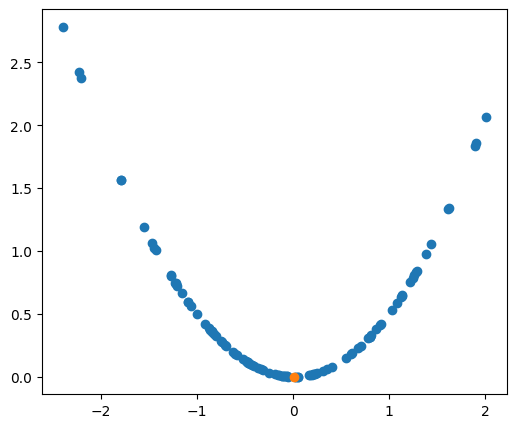

In [30]:
def plot_candidate(opt):
    xs = torch.randn(100, 1) + opt
    optima = optimal_model.forward(xs.to(optimal_model.device)).squeeze()

    plt.scatter(xs, optima.cpu().detach())
    plt.scatter(opt.squeeze(), optimal_model.forward(opt.to(optimal_model.device)).cpu().detach()) 

plot_candidate(torch.tensor([[0.00870278]]))

Newton works, but it is limited to scalar....